## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [10]:
import torch.optim as optim

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:04<00:00, 5.75MB/s]


Extracting fmnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 474kB/s]


Extracting fmnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:00<00:00, 4.96MB/s]


Extracting fmnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to fmnist\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting fmnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to fmnist\FashionMNIST\raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [12]:
# Training utilities
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=20, early_stop_patience=5):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    best_test_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validation phase
        model.eval()
        test_loss, test_correct, test_total = 0, 0, 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                
                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()

        # Record metrics
        train_accuracy = 100 * train_correct / train_total
        test_accuracy = 100 * test_correct / test_total
        train_losses.append(train_loss / len(train_loader))
        test_losses.append(test_loss / len(test_loader))
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}: Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

        # Early stopping
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stop_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, test_losses, train_accuracies, test_accuracies, best_test_accuracy

# Plotting function
def plot_training_results(train_losses, test_losses, train_accuracies, test_accuracies, title):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


Your experiments come here:

In [16]:
# Experiment setup
batch_size = 128
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=2)


--- Task 1: Basic Network ---
Epoch 1: Train Acc: 79.83%, Test Acc: 83.43%
Epoch 2: Train Acc: 85.11%, Test Acc: 84.97%
Epoch 3: Train Acc: 86.32%, Test Acc: 84.55%
Epoch 4: Train Acc: 87.18%, Test Acc: 86.53%
Epoch 5: Train Acc: 87.91%, Test Acc: 86.15%
Epoch 6: Train Acc: 88.30%, Test Acc: 86.64%
Epoch 7: Train Acc: 88.77%, Test Acc: 86.68%
Epoch 8: Train Acc: 89.14%, Test Acc: 86.58%
Epoch 9: Train Acc: 89.41%, Test Acc: 87.00%
Epoch 10: Train Acc: 89.78%, Test Acc: 87.04%
Epoch 11: Train Acc: 90.17%, Test Acc: 87.75%
Epoch 12: Train Acc: 90.27%, Test Acc: 87.58%
Epoch 13: Train Acc: 90.64%, Test Acc: 88.01%
Epoch 14: Train Acc: 90.75%, Test Acc: 88.20%
Epoch 15: Train Acc: 91.10%, Test Acc: 88.44%
Epoch 16: Train Acc: 91.22%, Test Acc: 88.20%
Epoch 17: Train Acc: 91.34%, Test Acc: 87.92%
Epoch 18: Train Acc: 91.62%, Test Acc: 88.23%
Epoch 19: Train Acc: 91.83%, Test Acc: 88.31%
Epoch 20: Train Acc: 91.93%, Test Acc: 88.17%
Early stopping at epoch 20


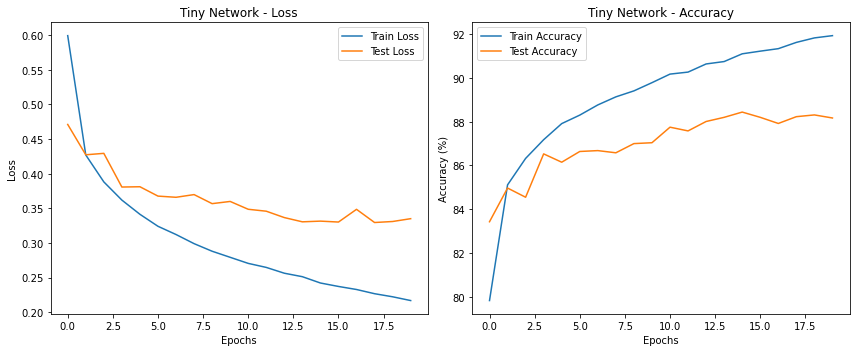

In [17]:
print("\n--- Task 1: Basic Network ---")
tiny_model = TinyNeuralNetwork().to(device)
tiny_optimizer = optim.Adam(tiny_model.parameters(), lr=0.001)
tiny_criterion = nn.CrossEntropyLoss()

tiny_train_losses, tiny_test_losses, tiny_train_accuracies, tiny_test_accuracies, tiny_best_accuracy = train_and_evaluate(
    tiny_model, train_loader, test_loader, tiny_criterion, tiny_optimizer
)
plot_training_results(tiny_train_losses, tiny_test_losses, tiny_train_accuracies, tiny_test_accuracies, 'Tiny Network')


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [18]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)

In [19]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 128]          32,896
              ReLU-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 567,434
Trainable params: 567,434
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.16
Estimated Total Size (MB): 2.19
----------------------------------------------------------------



--- Task 2: Overfitting Network ---
Epoch 1: Train Acc: 79.70%, Test Acc: 83.79%
Epoch 2: Train Acc: 86.24%, Test Acc: 86.53%
Epoch 3: Train Acc: 87.86%, Test Acc: 86.60%
Epoch 4: Train Acc: 88.51%, Test Acc: 87.36%
Epoch 5: Train Acc: 89.29%, Test Acc: 87.74%
Epoch 6: Train Acc: 89.81%, Test Acc: 88.52%
Epoch 7: Train Acc: 90.27%, Test Acc: 87.83%
Epoch 8: Train Acc: 90.64%, Test Acc: 88.34%
Epoch 9: Train Acc: 91.14%, Test Acc: 88.36%
Epoch 10: Train Acc: 91.39%, Test Acc: 88.22%
Epoch 11: Train Acc: 91.74%, Test Acc: 88.70%
Epoch 12: Train Acc: 91.92%, Test Acc: 87.99%
Epoch 13: Train Acc: 92.34%, Test Acc: 88.93%
Epoch 14: Train Acc: 92.82%, Test Acc: 89.24%
Epoch 15: Train Acc: 92.87%, Test Acc: 89.12%
Epoch 16: Train Acc: 93.08%, Test Acc: 88.48%
Epoch 17: Train Acc: 93.11%, Test Acc: 88.77%
Epoch 18: Train Acc: 93.62%, Test Acc: 89.15%
Epoch 19: Train Acc: 93.75%, Test Acc: 89.30%
Epoch 20: Train Acc: 93.93%, Test Acc: 89.36%


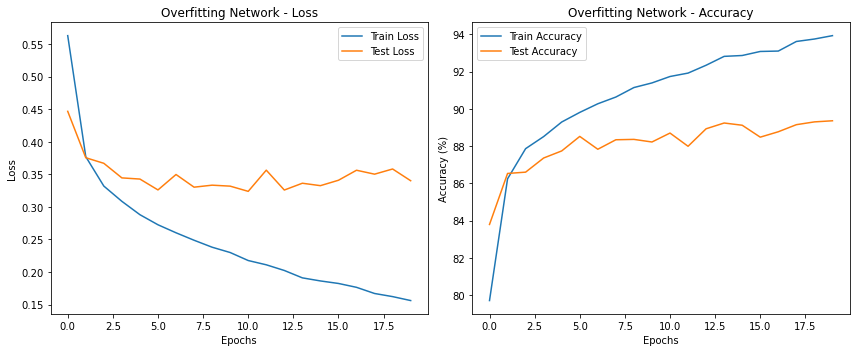

In [20]:
print("\n--- Task 2: Overfitting Network ---")
overfit_model = OverfittingNeuralNetwork().to(device)
overfit_optimizer = optim.Adam(overfit_model.parameters(), lr=0.001)
overfit_criterion = nn.CrossEntropyLoss()

overfit_train_losses, overfit_test_losses, overfit_train_accuracies, overfit_test_accuracies, overfit_best_accuracy = train_and_evaluate(
    overfit_model, train_loader, test_loader, overfit_criterion, overfit_optimizer
)
plot_training_results(overfit_train_losses, overfit_test_losses, overfit_train_accuracies, overfit_test_accuracies, 'Overfitting Network')


### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [22]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.model(x)



--- Task 3: Regularized Network ---
Epoch 1: Train Acc: 81.82%, Test Acc: 84.27%
Epoch 2: Train Acc: 85.88%, Test Acc: 86.45%
Epoch 3: Train Acc: 86.96%, Test Acc: 87.01%
Epoch 4: Train Acc: 87.86%, Test Acc: 87.16%
Epoch 5: Train Acc: 88.26%, Test Acc: 87.01%
Epoch 6: Train Acc: 88.82%, Test Acc: 87.81%
Epoch 7: Train Acc: 89.20%, Test Acc: 87.85%
Epoch 8: Train Acc: 89.59%, Test Acc: 88.11%
Epoch 9: Train Acc: 89.87%, Test Acc: 88.83%
Epoch 10: Train Acc: 90.08%, Test Acc: 89.01%
Epoch 11: Train Acc: 90.49%, Test Acc: 88.24%
Epoch 12: Train Acc: 90.60%, Test Acc: 88.33%
Epoch 13: Train Acc: 90.86%, Test Acc: 89.02%
Epoch 14: Train Acc: 91.08%, Test Acc: 88.52%
Epoch 15: Train Acc: 91.31%, Test Acc: 89.11%
Epoch 16: Train Acc: 91.45%, Test Acc: 89.43%
Epoch 17: Train Acc: 91.78%, Test Acc: 89.01%
Epoch 18: Train Acc: 91.89%, Test Acc: 88.58%
Epoch 19: Train Acc: 92.06%, Test Acc: 88.46%
Epoch 20: Train Acc: 92.20%, Test Acc: 88.09%


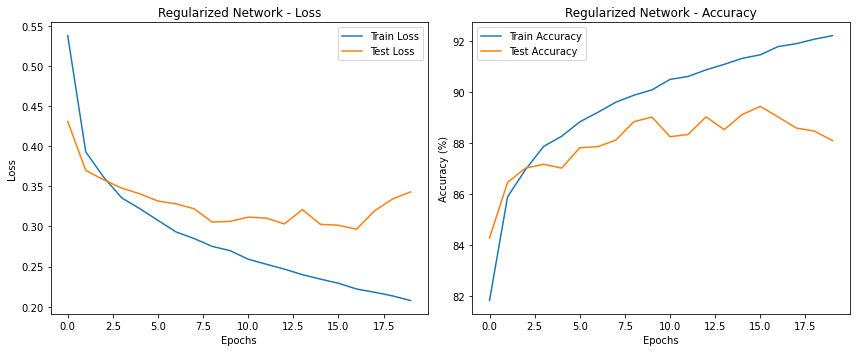

In [23]:
print("\n--- Task 3: Regularized Network ---")
fixed_model = FixedNeuralNetwork().to(device)
fixed_optimizer = optim.Adam(fixed_model.parameters(), lr=0.001, weight_decay=1e-5)
fixed_criterion = nn.CrossEntropyLoss()

fixed_train_losses, fixed_test_losses, fixed_train_accuracies, fixed_test_accuracies, fixed_best_accuracy = train_and_evaluate(
    fixed_model, train_loader, test_loader, fixed_criterion, fixed_optimizer
)
plot_training_results(fixed_train_losses, fixed_test_losses, fixed_train_accuracies, fixed_test_accuracies, 'Regularized Network')


In [24]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
              ReLU-4                  [-1, 512]               0
           Dropout-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
       BatchNorm1d-7                  [-1, 256]             512
              ReLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                  [-1, 128]          32,896
      BatchNorm1d-11                  [-1, 128]             256
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   


--- Task 3: Regularized Network ---
Epoch 1: Train Acc: 81.47%, Test Acc: 85.19%
Epoch 2: Train Acc: 85.72%, Test Acc: 86.03%
Epoch 3: Train Acc: 86.92%, Test Acc: 87.18%
Epoch 4: Train Acc: 87.71%, Test Acc: 87.78%
Epoch 5: Train Acc: 88.25%, Test Acc: 87.00%
Epoch 6: Train Acc: 88.77%, Test Acc: 88.18%
Epoch 7: Train Acc: 89.19%, Test Acc: 87.83%
Epoch 8: Train Acc: 89.49%, Test Acc: 88.52%
Epoch 9: Train Acc: 89.89%, Test Acc: 88.16%
Epoch 10: Train Acc: 90.12%, Test Acc: 88.01%
Epoch 11: Train Acc: 90.56%, Test Acc: 88.32%
Epoch 12: Train Acc: 90.70%, Test Acc: 88.38%
Epoch 13: Train Acc: 91.04%, Test Acc: 89.43%
Epoch 14: Train Acc: 91.08%, Test Acc: 88.79%
Epoch 15: Train Acc: 91.35%, Test Acc: 88.96%
Epoch 16: Train Acc: 91.52%, Test Acc: 89.18%
Epoch 17: Train Acc: 91.90%, Test Acc: 89.63%
Epoch 18: Train Acc: 92.09%, Test Acc: 89.28%
Epoch 19: Train Acc: 92.23%, Test Acc: 89.40%
Epoch 20: Train Acc: 92.24%, Test Acc: 89.41%


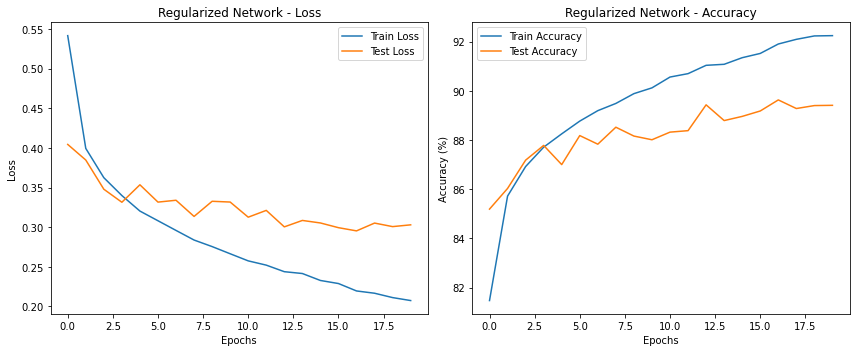

In [25]:
print("\n--- Task 3: Regularized Network ---")
fixed_model = FixedNeuralNetwork().to(device)
fixed_optimizer = optim.Adam(fixed_model.parameters(), lr=0.001, weight_decay=1e-5)
fixed_criterion = nn.CrossEntropyLoss()

fixed_train_losses, fixed_test_losses, fixed_train_accuracies, fixed_test_accuracies, fixed_best_accuracy = train_and_evaluate(
    fixed_model, train_loader, test_loader, fixed_criterion, fixed_optimizer
)
plot_training_results(fixed_train_losses, fixed_test_losses, fixed_train_accuracies, fixed_test_accuracies, 'Regularized Network')


### Conclusions:
_Write down small report with your conclusions and your ideas._

In [26]:
# Comparative Summary
print("\n--- Results Summary ---")
print(f"Tiny Network Best Accuracy: {tiny_best_accuracy:.2f}%")
print(f"Overfitting Network Best Accuracy: {overfit_best_accuracy:.2f}%")
print(f"Regularized Network Best Accuracy: {fixed_best_accuracy:.2f}%")


--- Results Summary ---
Tiny Network Best Accuracy: 88.44%
Overfitting Network Best Accuracy: 89.36%
Regularized Network Best Accuracy: 89.63%


In [28]:
"""
Выводы:

Базовая сеть (Задача 1):

Простая сеть с одним скрытым слоем достигла высокой точности 88.44%
Демонстрирует эффективность даже простой архитектуры для классификации Fashion-MNIST
Усложненная сеть (задача 2):

Увеличение сложности сети (добавление слоев) позволило немного улучшить точность до 89.36%
Незначительный прирост производительности по сравнению с базовой моделью
Не наблюдается существенного переобучения, как предполагалось изначально
Регуляризованная сеть (Задача 3):

Применение техник регуляризации (BatchNorm, Dropout, Weight Decay) позволило достичь лучшей точности 89.63%
Продемонстрировало небольшое, но стабильное улучшение обобщающей способности модели
Техники регуляризации помогают сети лучше адаптироваться к тестовым данным
Ключевые наблюдения:

Сложность сети не всегда гарантирует существенное улучшение производительности
Методы регуляризации могут помочь в тонкой настройке модели
Для данного набора данных (Fashion-MNIST) даже базовая архитектура показывает высокую эффективность
Разница в точности между моделями составляет менее 1.2%, что указывает на устойчивость модели
"""

'\nВыводы:\n\nБазовая сеть (Задача 1):\n\nПростая сеть с одним скрытым слоем достигла высокой точности 88.44%\nДемонстрирует эффективность даже простой архитектуры для классификации Fashion-MNIST\nУсложненная сеть (задача 2):\n\nУвеличение сложности сети (добавление слоев) позволило немного улучшить точность до 89.36%\nНезначительный прирост производительности по сравнению с базовой моделью\nНе наблюдается существенного переобучения, как предполагалось изначально\nРегуляризованная сеть (Задача 3):\n\nПрименение техник регуляризации (BatchNorm, Dropout, Weight Decay) позволило достичь лучшей точности 89.63%\nПродемонстрировало небольшое, но стабильное улучшение обобщающей способности модели\nТехники регуляризации помогают сети лучше адаптироваться к тестовым данным\nКлючевые наблюдения:\n\nСложность сети не всегда гарантирует существенное улучшение производительности\nМетоды регуляризации могут помочь в тонкой настройке модели\nДля данного набора данных (Fashion-MNIST) даже базовая архи